In [ ]:
# SPDX-FileCopyrightText: 2022 Aleksander Grochowicz
#
# SPDX-License-Identifier: GPL-3.0-or-later

In [1]:
import copy
import pandas as pd
import scipy as sp
import numpy as np

from itertools import product

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import mpl_toolkits.mplot3d as a3
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 150
import seaborn as sns

from utilities import (sim_no_flex, sim_trans, sim_storage, sim_full_flex)

In [2]:
# Use the pgf backend for pdf exports (allows us to use xelatex).
from matplotlib.backends.backend_pgf import FigureCanvasPgf
mpl.backend_bases.register_backend('pdf', FigureCanvasPgf)

# Set up font.
plt.rcParams.update({
    "axes.formatter.limits": [-3,3], # Use scientific notation for large numbers.
    "font.family": "serif",  # use serif/main font for text elements
    "text.usetex": True,     # use inline math for ticks
    "pgf.rcfonts": False,    # don't setup fonts from rc parameters
    "pgf.texsystem": "lualatex",
    "pgf.preamble": "\n".join([
         r"\usepackage{unicode-math}",
         r"\setmainfont{TeX Gyre Termes}",
         r"\setmathfont{TeX Gyre Termes Math}",
    ])
})

cm = 1/2.54  # centimetres in inches

In [3]:
cs = {
    "yellow": "#faecbe",
    "rose": "#f7cacd",
    "purple": "#d6b0d6",
    "burgundy": "#8a5066",
    "pink": "#8a5066",
    "blue": "#5c8bc4"
}

In [4]:
def plot_mismatch(mismatches, quantile = 0.1, ax=None, colour = '#b05c17', alpha=0.3, linecolor = None):
    if ax is None:
        fig, ax = plt.subplots()
    # Compute quantiles:
    quantiles_upper = mismatches.quantile(q=1 - quantile, axis=1)
    quantiles_lower = mismatches.quantile(q = quantile, axis=1)
    ax.plot(mismatches.mean(axis=1), label = "Mean", color = linecolor)
    ax.fill_between(mismatches.index, quantiles_lower, quantiles_upper, color = colour, label = f"{int(100*(1-2*quantile))}\% probability range", alpha=alpha);
    ax.set_xlim(0,365)
    return ax

# Initiation

In [5]:
simulation = "./results/standard.csv"
scenarios = ["no-flex", "trans", "stor", "full-flex"]
regions = ["NO-N", "NO-S"]
sample_length = 100
batch_size = 100
save_fig = True
save_files = False

# Use initial capacities from NVE, accessed 22/11/2022.
initial_capacities = np.array([3257.,1811.])

# Use standard assumptions.
storage_cap = np.array([15000.,30000.]) # enough to cover the max wind demand for more than two weeks
generation_cap = np.array([900.,900.]) # should be comparable to transmission
transmission_cap = 900. # Statnett, accessed 22/11/2022

## Efficiencies
eff_c = 0.75 # PyPSA-Eur efficiency for pumped hydro storage (charge)
eff_d = 0.9 # PyPSA-Eur efficiency for usual hydro (discharge)

# Load optimal capacities.
capacities = pd.read_csv(simulation, index_col=0)
optimal_capacities = pd.DataFrame(capacities.loc[capacities.idxmin()[scenarios]][regions].values, index = scenarios, columns = regions)

# Overwrite by initial capacities, if below them.
for i in optimal_capacities.index:
    if optimal_capacities.loc[i, "NO-N"] == 3250:
        optimal_capacities.loc[i, "NO-N"] = 3257
    if optimal_capacities.loc[i, "NO-S"] == 1800:
        optimal_capacities.iloc[i, "NO-S"] = 1811


In [6]:
# Data set-up
cf_ts = pd.read_csv(f"./data/processing/norway_regions_production_corr_{sample_length}y.csv", index_col=0)
dem_ts = pd.read_csv(f"./data/processing/demand_norway_{sample_length}y.csv", index_col=0)/24 # Convert to hourly averages
dem_ts *= 0.128 # calculation based on NVE, accessed 22/11/2022, and Nordpool data

In [7]:
optimal_capacities

,NO-N,NO-S
no-flex,3257.0,4700.0
trans,3257.0,3800.0
stor,3257.0,6450.0
full-flex,3257.0,5550.0


# Simulation in the optima

## Scenario 0:

In [8]:
penalties_orig, mismatches_orig = sim_no_flex(initial_capacities,batch_size=batch_size, cap_factors_data=cf_ts, demand_data=dem_ts)

penalties_orig_trans, mismatches_orig_trans, imports_orig_trans, exports_orig_trans = sim_trans(initial_capacities, transmission_cap, batch_size=batch_size, cap_factors_data=cf_ts, demand_data=dem_ts)

penalties_orig_storage, mismatches_orig_storage, su_orig_storage, sl_orig_storage = sim_storage(initial_capacities, storage_cap,generation_cap, generation_cap,batch_size,cf_ts, dem_ts, eff_c, eff_d)

penalties_orig_flex, mismatches_orig_flex, imports_orig_flex, exports_orig_flex, su_orig_flex, sl_orig_flex = sim_full_flex(initial_capacities,transmission_cap,storage_cap,generation_cap, generation_cap,batch_size,cf_ts, dem_ts, eff_c, eff_d)

Plot with penalty values for all scenarios based on current capacities.

In [9]:
# new colour scheme:
# yellow: #faecbe
# pastel pink: #f7cacd
# pastel purple: #d6b0d6
# pastel burgundy: #8a5066
# pink: #8a5066
# blue: #5c8bc4



In [10]:
colours = ["grey", "black", cs["purple"], cs["blue"], "darkolivegreen"]
scenario_names = ["orig", "no-flex", "trans", "stor", "full-flex"]

In [11]:
# # Plot penalties with quantiles.

# quantile = 0.1
# fig, ax = plt.subplots(2,1, figsize=(7.5*cm, 10*cm), sharex=True)
# for i,loc in enumerate(["NO-N", "NO-S"]):
#     for c, s, n in zip(colours[1:], [penalties_orig, penalties_orig_trans, penalties_orig_storage, penalties_orig_flex], scenario_names[1:]):
#         ax[i].plot(s[loc].mean(axis=1), c=c, label=n);
#     ax[i].set_title(f"{loc}");
#     ax[i].set_ylabel("Penalty values");
#     ax[i].set_xlim(0,365)
# ax[1].set_xlabel("Day");
# handles, labels = ax[1].get_legend_handles_labels()
# ax[1].legend(handles, labels, bbox_to_anchor=(-0.2,-0.25), ncol=4, loc='upper left', fontsize=8, frameon=False);
# if save_fig:
#     fig.savefig("./figures/current_capacities.pdf", bbox_inches="tight")

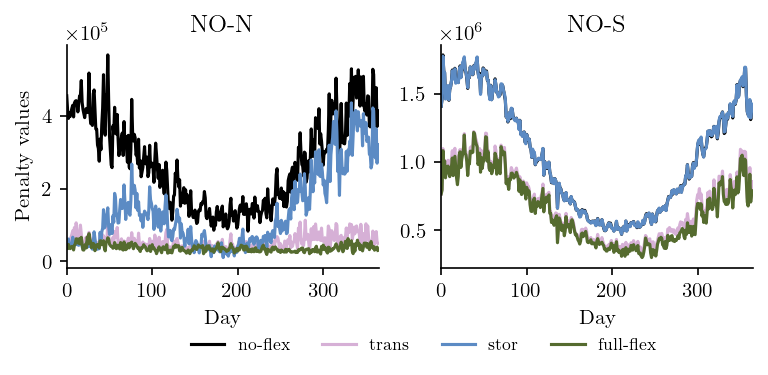

In [12]:
# Column-based
# Plot penalties with quantiles.

quantile = 0.1
fig, ax = plt.subplots(1,2, figsize=(15*cm, 5*cm), sharex=True)
for i,loc in enumerate(["NO-N", "NO-S"]):
    for c, s, n in zip(colours[1:], [penalties_orig, penalties_orig_trans, penalties_orig_storage, penalties_orig_flex], scenario_names[1:]):
        ax[i].plot(s[loc].mean(axis=1), c=c, label=n);
    ax[i].set_title(f"{loc}");
    ax[i].set_xlabel("Day");
    ax[i].set_xlim(0,365)
ax[0].set_ylabel("Penalty values");
handles, labels = ax[1].get_legend_handles_labels()
ax[1].legend(handles, labels, bbox_to_anchor=(-0.85,-0.25), ncol=4, loc='upper left', fontsize=8, frameon=False);

for axis in ax.flatten():
    for loc in ["top", "right"]:
        axis.spines[loc].set_visible(False)
if save_fig:
   fig.savefig("./figures/current_capacities_twocolumns.pdf", bbox_inches="tight")

,NO-N,NO-S
no-flex \n (2022),1.0,1.0
trans \n (2022),0.199007,0.662163
stor \n (2022),0.488724,0.990355
full-flex \n (2022),0.135795,0.629347


,sum
no-flex \n (2022),1.0
trans \n (2022),0.565869
stor \n (2022),0.886061
full-flex \n (2022),0.526733


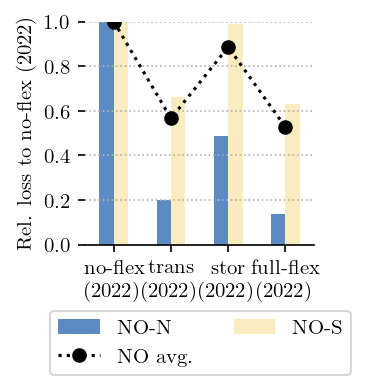

In [13]:
# Improvement through flexibility in original capacities
flex_improvement = pd.DataFrame(index = ["no-flex \n (2022)", "trans \n (2022)", "stor \n (2022)", "full-flex \n (2022)"], columns = ["NO-N", "NO-S"])
total_improvement = pd.DataFrame(index = ["no-flex \n (2022)", "trans \n (2022)", "stor \n (2022)", "full-flex \n (2022)"], columns = ["sum"])
for i in flex_improvement.columns:
    for j, value in zip(flex_improvement.index, [penalties_orig, penalties_orig_trans, penalties_orig_storage, penalties_orig_flex]):
        flex_improvement.loc[j,i] = value[i].sum(axis=0).mean()/penalties_orig[i].sum(axis=0).mean()
for j, value in zip(total_improvement.index, [penalties_orig, penalties_orig_trans, penalties_orig_storage, penalties_orig_flex]):
        total_improvement.loc[j, "sum"] = pd.concat(value).sum(axis=0).mean()/pd.concat(penalties_orig).sum(axis=0).mean()
fig, ax = plt.subplots(figsize=(5*cm, 5*cm))
total_improvement.plot(ax=ax, color="black", marker="o", ls="dotted")
flex_improvement.plot.bar(rot=0, ax=ax, color = [cs["blue"], cs["yellow"]])

ax.grid(ls="dotted", axis="y")
ax.set_ylim(0,1)
ax.set_ylabel("Rel. loss to no-flex (2022)")
handles, labels = ax.get_legend_handles_labels()
ax.legend([handles[1], handles[0], handles[2]], ["NO-N", "NO avg.", "NO-S",], ncol=2, bbox_to_anchor=(-0.2,-0.25), loc='upper left')
for loc in ["right", "top", "left"]:
    ax.spines[loc].set_visible(False)
if save_fig:
    fig.savefig("./figures/current_scenarios.pdf", bbox_inches="tight")
    fig.savefig("./figures/paper_plots/current_scenarios.pdf", bbox_inches="tight")
display(flex_improvement)
display(total_improvement)

## Scenario 1: No flexibility

In [14]:
penalties, mismatches = sim_no_flex(x=optimal_capacities.loc["no-flex"],batch_size=batch_size, cap_factors_data=cf_ts, demand_data=dem_ts)

Seasonal profiles of wind CFs and demand.

In [15]:
avg_dem = pd.DataFrame(index=range(365), columns = dem_ts.columns)
for i in range(365):
    avg_dem.loc[i] = dem_ts.loc[i::365].mean()
avg_cp = pd.DataFrame(index=range(365), columns = cf_ts.columns)
for i in range(365):
    avg_cp.loc[i] = cf_ts.loc[i::365].mean()

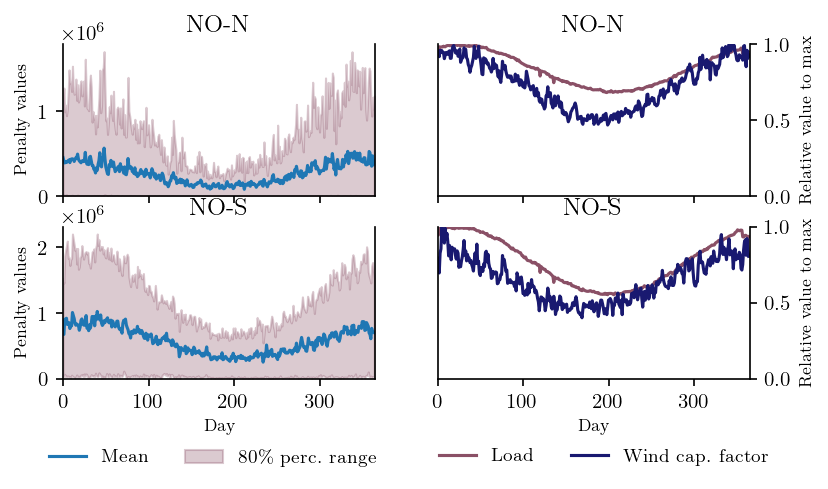

In [16]:
# Plot penalties with quantiles; plot seasonality of wind and load.

quantile = 0.1
fig, ax = plt.subplots(2,2, figsize=(15*cm, 7.5*cm), sharex=True)
for i,loc in enumerate(["NO-N", "NO-S"]):
    plot_mismatch(penalties[loc], quantile=quantile,ax=ax[i,0], colour = cs["pink"]);
    ax[i,0].set_title(f"{loc}");
    ax[i,0].set_ylabel("Penalty values", fontsize=8);
    ax[i,0].set_ylim(bottom=0);
ax[1,0].set_xlabel("Day", fontsize=8);
handles, labels = ax[1,0].get_legend_handles_labels()
ax[1,0].legend(handles, ["Mean", "80\% perc. range"], bbox_to_anchor=(-0.1,-0.35), ncol=2, loc='upper left', fontsize=9, frameon=False);
for j, name in enumerate(["NO-N", "NO-S"]):
    ax[j,1].plot(avg_dem[name]/avg_dem.max()[name], label = "Load", color=cs["burgundy"])
    ax[j,1].plot(avg_cp[name]/avg_cp.max()[name], label = "Wind cap. factor", color="midnightblue")
    ax[j,1].set_title(f"{name}");
    ax[j,i].set_ylim(0,1)
    ax[j,1].set_ylabel(f"Relative value to max", fontsize=8);
    ax[j,i].yaxis.set_label_position("right")
    ax[j,i].yaxis.tick_right()
ax[1,1].set_xlabel("Day", fontsize=8);
ax[1,1].legend(bbox_to_anchor=(-0.05,-0.35), ncol=2, loc='upper left', fontsize=9, frameon=False);
for axis in ax.flatten():
    for loc in ["top"]:
        axis.spines[loc].set_visible(False)
    

if save_fig:
    fig.savefig("./figures/no-flex_penalties_seasonal.pdf", bbox_inches='tight')
    fig.savefig("./figures/paper_plots/no-flex_penalties_seasonal.pdf", bbox_inches='tight')

In [17]:
# quantile = 0.1
# fig, ax = plt.subplots(2,1, figsize=(7.5*cm, 7.5*cm), sharex=True)
# for i,loc in enumerate(["NO-N", "NO-S"]):
#     plot_mismatch(penalties[loc], quantile=quantile,ax=ax[i]);
#     ax[i].set_title(f"{loc}");
#     ax[i].set_ylabel("Penalty values", fontsize=8);
#     ax[i].set_ylim(bottom=0);
# ax[1].set_xlabel("Day", fontsize=8);
# handles, labels = ax[1].get_legend_handles_labels()
# ax[1].legend(handles, ["Mean", "80\% perc. range"], bbox_to_anchor=(-0.1,-0.35), ncol=2, loc='upper left', fontsize=9, frameon=False);
# if save_fig:
#     fig.savefig("./figures/no-flex_penalties_column.pdf", bbox_inches='tight')

# fig, ax = plt.subplots(2,1, figsize=(7.5*cm, 7.5*cm), sharex=True)
# for j, name in enumerate(["NO-N", "NO-S"]):
#     ax[j].plot(avg_dem[name]/avg_dem.max()[name], label = "Load", color="green")
#     ax[j].plot(avg_cp[name]/avg_cp.max()[name], label = "Wind cap. factor", color="red")
#     ax[j].set_title(f"{name}");
#     ax[j].set_ylim(0,1)
#     ax[j].set_xlim(0,365)
#     ax[j].set_ylabel(f"Relative value to max", fontsize=8);
# ax[1].set_xlabel("Day", fontsize=8);
# ax[1].legend(bbox_to_anchor=(-0.05,-0.35), ncol=2, loc='upper left', fontsize=9, frameon=False);
# if save_fig:
#     fig.savefig("./figures/seasonal-avgs_column.pdf", bbox_inches='tight')

## Scenario 2: Transmission

In [18]:
penalties_trans, mismatches_trans, imports_trans, exports_trans = sim_trans(optimal_capacities.loc["trans"], transmission_cap, batch_size=100, cap_factors_data=cf_ts, demand_data=dem_ts)

Plot 1: average penalty with quantiles throughout the calendar year.

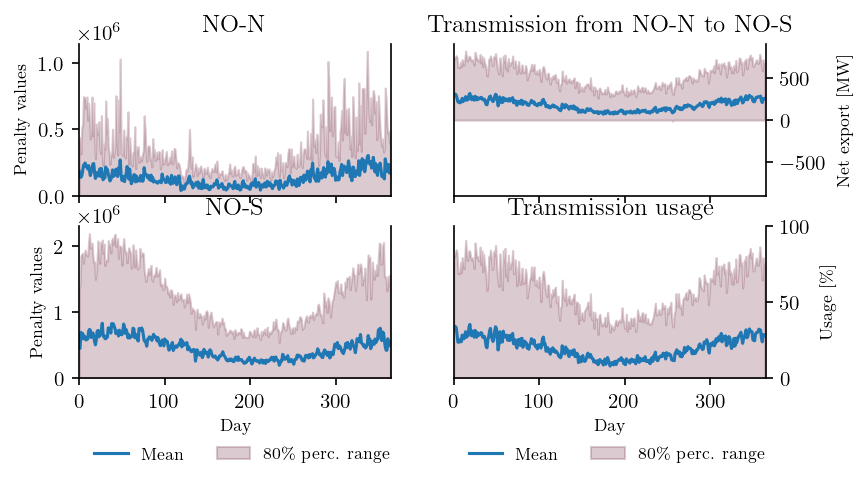

In [19]:
# Plot penalties with quantiles; plot exports and transmission usage with quantiles.

quantile = 0.1
fig, ax = plt.subplots(2,2, figsize=(15*cm, 7.5*cm), sharex=True)
for i,loc in enumerate(["NO-N", "NO-S"]):
    plot_mismatch(penalties_trans[loc], quantile=quantile,ax=ax[i,0], colour = cs["pink"]);
    ax[i,0].set_title(f"{loc}");
    ax[i,0].set_ylabel("Penalty values", fontsize=8);
    ax[i,0].set_ylim(bottom=0);
ax[1,0].set_xlabel("Day", fontsize=8);
handles, labels = ax[1,0].get_legend_handles_labels()
ax[1,0].legend(handles, ["Mean", "80\% perc. range"], bbox_to_anchor=(0,-0.35), ncol=2, loc='upper left', fontsize=8, frameon=False);


plot_mismatch((exports_trans["NO-N"]-imports_trans["NO-N"]), quantile=quantile,ax=ax[0,1], colour = cs["pink"]);
ax[0,1].set_title(f"Transmission from NO-N to NO-S");
ax[0,1].set_ylabel("Net export [MW]", fontsize=8)
ax[0,1].yaxis.set_label_position("right")
ax[0,1].yaxis.tick_right()
ax[0,1].set_ylim(bottom=-900, top=900);


plot_mismatch(100*(exports_trans[loc]+imports_trans[loc])/(900), quantile=quantile,ax=ax[1,1], colour = cs["pink"]);
ax[1,1].set_title(f"Transmission usage");
ax[1,1].set_ylabel("Usage [\%]", fontsize=8);
ax[1,1].set_xlabel("Day", fontsize=8);
ax[1,1].yaxis.set_label_position("right")
ax[1,1].yaxis.tick_right()
ax[1,1].set_ylim(bottom=0, top=100);
handles, labels = ax[1,1].get_legend_handles_labels()
ax[1,1].legend(handles, ["Mean", "80\% perc. range"], bbox_to_anchor=(0,-0.35), ncol=2, loc='upper left', fontsize=8, frameon=False);

for axis in ax.flatten():
    axis.spines["top"].set_visible(False)
if save_fig:
    fig.savefig("./figures/trans_penalties_exports.pdf", bbox_inches='tight')
    fig.savefig("./figures/paper_plots/trans_penalties_exports.pdf", bbox_inches='tight')

In [20]:
# # Plot penalties with quantiles; plot exports and transmission usage with quantiles.

# quantile = 0.1
# fig, ax = plt.subplots(2,1, figsize=(7.5*cm, 7.5*cm), sharex=True)
# for i,loc in enumerate(["NO-N", "NO-S"]):
#     plot_mismatch(penalties_trans[loc], quantile=quantile,ax=ax[i]);
#     ax[i].set_title(f"{loc}");
#     ax[i].set_ylabel("Penalty values", fontsize=8);
#     ax[i].set_ylim(bottom=0);
# ax[1].set_xlabel("Day", fontsize=8);
# handles, labels = ax[1].get_legend_handles_labels()
# ax[1].legend(handles, ["Mean", "80\% perc. range"], bbox_to_anchor=(0,-0.35), ncol=2, loc='upper left', fontsize=8, frameon=False);
# if save_fig:
#     fig.savefig("./figures/trans_penalties_column.pdf", bbox_inches='tight')

# fig, ax = plt.subplots(2,1, figsize=(7.5*cm, 7.5*cm), sharex=True)
# plot_mismatch((exports_trans["NO-N"]-imports_trans["NO-N"]), quantile=quantile,ax=ax[0]);
# ax[0].set_title(f"Transmission from NO-N to NO-S");
# ax[0].set_ylabel("Net export [MW]", fontsize=8)
# #ax[0].yaxis.set_label_position("right")
# #ax[0].yaxis.tick_right()
# ax[0].set_ylim(bottom=-900, top=900);


# plot_mismatch(100*(exports_trans[loc]+imports_trans[loc])/(900), quantile=quantile,ax=ax[1]);
# ax[1].set_title(f"Transmission usage");
# ax[1].set_ylabel("Usage [\%]", fontsize=8);
# ax[1].set_xlabel("Day", fontsize=8);
# #ax[1].yaxis.set_label_position("right")
# #ax[1].yaxis.tick_right()
# ax[1].set_ylim(bottom=0, top=100);
# handles, labels = ax[1].get_legend_handles_labels()
# ax[1].legend(handles, ["Mean", "80\% perc. range"], bbox_to_anchor=(0,-0.35), ncol=2, loc='upper left', fontsize=8, frameon=False);
# if save_fig:
#     fig.savefig("./figures/trans_exports_column.pdf", bbox_inches='tight')

Plot 2: Distribution of exports (summer vs. winter)

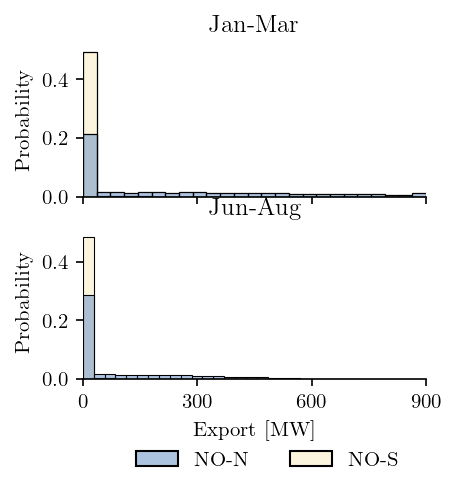

In [21]:
fig, axs = plt.subplots(2,1, figsize=(7.5*cm, 7.5*cm), sharex=True, sharey=True)

for slices, name, ax in zip([slice(0,90), slice(150,240)], ['Jan-Mar', 'Jun-Aug'],axs):
    if name=="Jun-Aug":
        hist = sns.histplot(data=(pd.concat(exports_trans)).loc[(slice(None),slices), :].unstack().T,ax=ax, legend=True, stat="probability", bins=25, palette=[cs["blue"], cs["yellow"]])
        sns.move_legend(ax, "upper left", bbox_to_anchor=(0.1,-0.35), ncol=2, frameon=False);
    else:
        sns.histplot(data=(pd.concat(exports_trans)).loc[(slice(None),slices), :].unstack().T,ax=ax, legend=False, stat="probability", bins=25, palette=[cs["blue"], cs["yellow"]]);
    ax.set_title(f"{name}");
    ax.xaxis.set_major_locator(ticker.MultipleLocator(300))
    # handles, labels = ax[3,1].get_legend_handles_labels();
    ax.set_xlabel("Export [MW]");
    # ax[3,1].legend(handles, ["NO-N", "NO-S"], bbox_to_anchor=(0,-0.25), ncol=2, loc='upper left', fontsize=9, frameon=False);
    ax.set_xlim(0,900)

for axis in axs.flatten():
    for loc in ["left", "right", "top"]:
        axis.spines[loc].set_visible(False)
if save_fig:
    fig.savefig("./figures/trans_exports-winter-summer.pdf", bbox_inches='tight')


## Scenario 3: Storage

In [22]:
penalties_storage, mismatches_storage, su_storage, sl_storage = sim_storage(optimal_capacities.loc["stor"], storage_cap,generation_cap, generation_cap,100,cf_ts, dem_ts, 0.75,0.9)


Plot 1: average penalty with quantiles throughout the calendar year

In [23]:
# # Plot penalties with quantiles.

# quantile = 0.1
# fig, axs = plt.subplots(2,1, figsize=(7.5*cm, 10*cm), sharex=True)
# for i,loc in enumerate(["NO-N", "NO-S"]):
#     plot_mismatch(penalties_storage[loc], quantile=quantile,ax=axs[i]);
#     axs[i].set_title(f"{loc}");
#     axs[i].set_ylabel("Penalty values", fontsize=8);
#     axs[i].set_ylim(bottom=0);
# axs[1].set_xlabel("Day", fontsize=8);
# handles, labels = axs[1].get_legend_handles_labels()
# axs[1].legend(handles, ["Mean", "80\% perc. range"], bbox_to_anchor=(0,-0.25), ncol=2, loc='upper left', fontsize=8, frameon=False);
# if save_fig:
#     fig.savefig("./figures/stor_penalties.pdf", bbox_inches='tight')

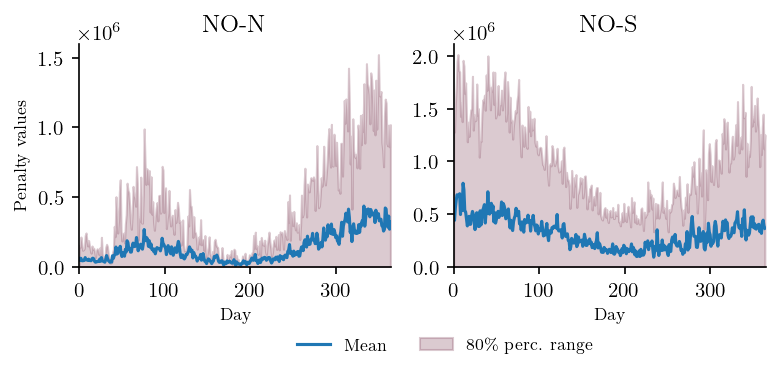

In [24]:
# Plot penalties with quantiles.

quantile = 0.1
fig, axs = plt.subplots(1,2, figsize=(15*cm, 5*cm), sharex=True)
for i,loc in enumerate(["NO-N", "NO-S"]):
    plot_mismatch(penalties_storage[loc], quantile=quantile,ax=axs[i], colour = cs["pink"]);
    axs[i].set_title(f"{loc}");
    axs[i].set_xlabel("Day", fontsize=8);
    axs[i].set_ylim(bottom=0);
axs[0].set_ylabel("Penalty values", fontsize=8);
handles, labels = axs[1].get_legend_handles_labels()
axs[1].legend(handles, ["Mean", "80\% perc. range"], bbox_to_anchor=(-0.55,-0.25), ncol=2, loc='upper left', fontsize=8, frameon=False);

for axis in axs.flatten():
    for loc in ["top", "right"]:
        axis.spines[loc].set_visible(False)
if save_fig:
    fig.savefig("./figures/stor_penalties_twocolumns.pdf", bbox_inches='tight')
    fig.savefig("./figures/paper_plots/stor_penalties.pdf", bbox_inches='tight')

Plot 2: Charging distribution in summer/winter

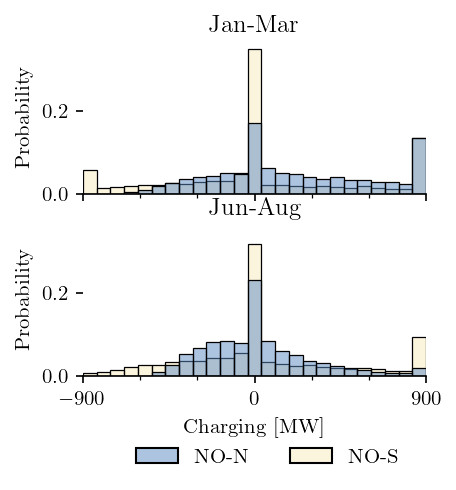

In [25]:
fig, axs = plt.subplots(2,1, figsize=(7.5*cm, 7.5*cm), sharex=True, sharey=True)
for slices, name, ax in zip([slice(0,90), slice(150,240)], ['Jan-Mar', 'Jun-Aug'],axs):
    if name=="Jun-Aug":
        sns.histplot(data=(pd.concat(su_storage)).loc[(slice(None),slices), :].unstack().T,ax=ax, legend=True, stat="probability", bins=25, common_norm=False, palette=[cs["blue"], cs["yellow"]]);
        sns.move_legend(ax, "upper left", bbox_to_anchor=(0.1,-0.35), ncol=2, frameon=False);
    else:
        sns.histplot(data=(pd.concat(su_storage)).loc[(slice(None),slices), :].unstack().T,ax=ax, legend=False, stat="probability", bins=25, common_norm=False, palette=[cs["blue"], cs["yellow"]]);
    ax.set_title(f"{name}", y=0.98);
    ax.xaxis.set_major_locator(ticker.MultipleLocator(900))
    ax.xaxis.set_minor_locator(ticker.MultipleLocator(300))
    ax.set_xlabel("Charging [MW]");

for axis in axs.flatten():
    for loc in ["left", "right", "top"]:
        axis.spines[loc].set_visible(False)
    axis.set_xlim(-900, 900)
if save_fig:
    fig.savefig("./figures/stor_usage-winter-summer.pdf", bbox_inches='tight')


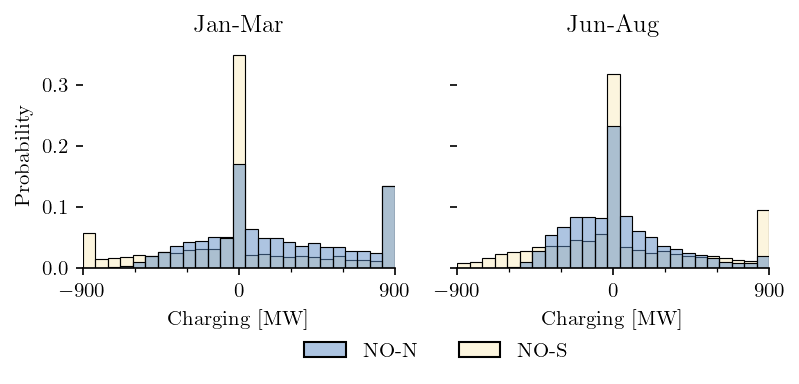

In [26]:
fig, axs = plt.subplots(1,2, figsize=(15*cm, 5*cm), sharex=True, sharey=True)
for slices, name, ax in zip([slice(0,90), slice(150,240)], ['Jan-Mar', 'Jun-Aug'],axs):
    if name=="Jun-Aug":
        sns.histplot(data=(pd.concat(su_storage)).loc[(slice(None),slices), :].unstack().T,ax=ax, legend=True, stat="probability", bins=25, common_norm=False, palette=[cs["blue"], cs["yellow"]]);
        sns.move_legend(ax, "upper left", bbox_to_anchor=(-0.55,-0.25), ncol=2, frameon=False);
    else:
        sns.histplot(data=(pd.concat(su_storage)).loc[(slice(None),slices), :].unstack().T,ax=ax, legend=False, stat="probability", bins=25, common_norm=False, palette=[cs["blue"], cs["yellow"]]);
    ax.set_title(f"{name}");
    ax.xaxis.set_major_locator(ticker.MultipleLocator(900))
    ax.xaxis.set_minor_locator(ticker.MultipleLocator(300))
    ax.set_xlabel("Charging [MW]");

for axis in axs.flatten():
    for loc in ["top", "right", "left"]:
        axis.spines[loc].set_visible(False)
    axis.set_xlim(-900, 900)
if save_fig:
    fig.savefig("./figures/stor_usage-winter-summer_twocolumns.pdf", bbox_inches='tight')
    fig.savefig("./figures/paper_plots/stor_usage.pdf", bbox_inches='tight')


Plot 3: Distribution of storage levels

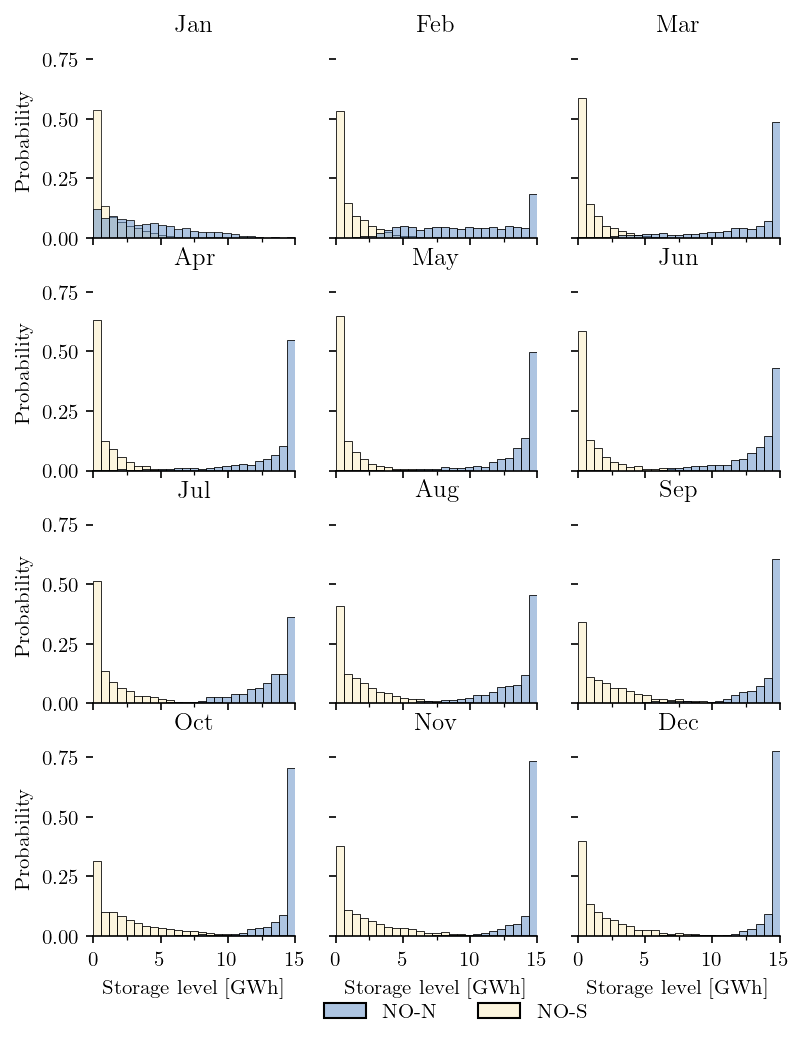

In [27]:
# Distribution of storage level by month

fig, ax = plt.subplots(4,3, figsize=(15*cm, 20*cm), sharex=True, sharey=True)
for months, name in zip(range(0,12), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']):
    if months==10:
        sns.histplot(data=(pd.concat(sl_storage)/1e3).loc[(slice(None),slice(months*30,(months+1)*30)), :].unstack().T,ax=ax[months//3, months%3], legend=True, stat="probability", bins=25, binrange=(0,15), common_norm=False, palette=[cs["blue"], cs["yellow"]]);
        sns.move_legend(ax[months//3, months%3], "upper left", bbox_to_anchor=(-0.15,-0.25), ncol=2, frameon=False);
    else:
        sns.histplot(data=(pd.concat(sl_storage)/1e3).loc[(slice(None),slice(months*30,(months+1)*30)), :].unstack().T,ax=ax[months//3, months%3], legend=False, stat="probability", bins=25, binrange=(0,15), common_norm=False, palette=[cs["blue"], cs["yellow"]]);
    ax[months//3, months%3].set_title(f"{name}");
    ax[months//3, months%3].xaxis.set_major_locator(ticker.MultipleLocator(5))
    ax[months//3, months%3].xaxis.set_minor_locator(ticker.MultipleLocator(2.5))
    ax[months//3, months%3].set_xlim(0,15)
    # handles, labels = ax[3,1].get_legend_handles_labels();
    ax[3,months%3].set_xlabel("Storage level [GWh]");
    # ax[3,1].legend(handles, ["NO-N", "NO-S"], bbox_to_anchor=(0,-0.25), ncol=2, loc='upper left', fontsize=9, frameon=False);

for axis in ax.flatten():
    for loc in ["left", "right", "top"]:
        axis.spines[loc].set_visible(False)
if save_fig:
    fig.savefig("./figures/stor_level-distr.pdf", bbox_inches='tight')
    fig.savefig("./figures/paper_plots/stor_level-distr.pdf", bbox_inches='tight')


## Scenario 4: Full flexibility

In [28]:
penalties_flex, mismatches_flex, imports_flex, exports_flex, su_flex, sl_flex = sim_full_flex(optimal_capacities.loc["full-flex"],transmission_cap,storage_cap,generation_cap, generation_cap,100,cf_ts, dem_ts, 0.75,0.9)

Plot 1: average penalty with quantiles throughout the calendar year

In [29]:
# # Plot penalties with quantiles.

# quantile = 0.1
# fig, axs = plt.subplots(2,1, figsize=(7.5*cm, 10*cm), sharex=True)
# for i,loc in enumerate(["NO-N", "NO-S"]):
#     plot_mismatch(penalties_flex[loc], quantile=quantile,ax=axs[i]);
#     axs[i].set_title(f"{loc}");
#     axs[i].set_ylabel("Penalty values", fontsize=8);
#     axs[i].set_ylim(bottom=0);
# axs[1].set_xlabel("Day", fontsize=8);
# handles, labels = axs[1].get_legend_handles_labels()
# axs[1].legend(handles, ["Mean", "80\% perc. range"], bbox_to_anchor=(0,-0.25), ncol=2, loc='upper left', fontsize=8, frameon=False);
# if save_fig:
#     fig.savefig("./figures/full-flex_penalties.pdf", bbox_inches='tight')

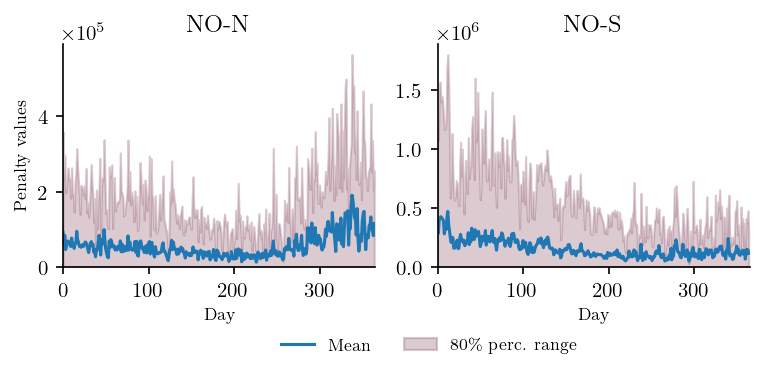

In [30]:
# Plot penalties with quantiles.

quantile = 0.1
fig, axs = plt.subplots(1,2, figsize=(15*cm, 5*cm), sharex=True)
for i,loc in enumerate(["NO-N", "NO-S"]):
    plot_mismatch(penalties_flex[loc], quantile=quantile,ax=axs[i], colour = cs["pink"]);
    axs[i].set_title(f"{loc}");
    axs[i].set_xlabel("Day", fontsize=8);
    axs[i].set_ylim(bottom=0);
axs[0].set_ylabel("Penalty values", fontsize=8);
handles, labels = axs[1].get_legend_handles_labels()
axs[1].legend(handles, ["Mean", "80\% perc. range"], bbox_to_anchor=(-0.55,-0.25), ncol=2, loc='upper left', fontsize=8, frameon=False);

for axis in axs.flatten():
    for loc in ["top", "right"]:
        axis.spines[loc].set_visible(False)
if save_fig:
    fig.savefig("./figures/full-flex_penalties_twocolumns.pdf", bbox_inches='tight')
    fig.savefig("./figures/paper_plots/full-flex_penalties.pdf", bbox_inches='tight')

Plot 2: Charging distribution

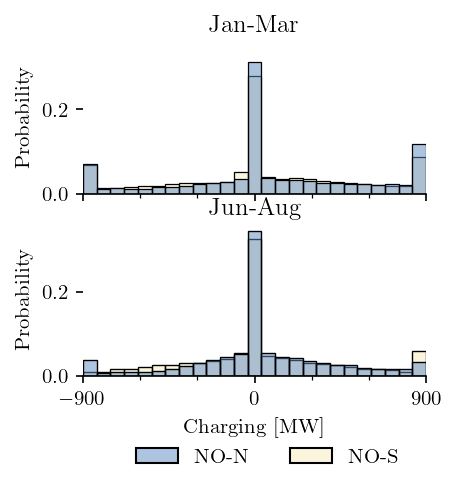

In [31]:
fig, axs = plt.subplots(2,1, figsize=(7.5*cm, 7.5*cm), sharex=True, sharey=True)
for slices, name, ax in zip([slice(0,90), slice(150,240)], ['Jan-Mar', 'Jun-Aug'],axs):
    if name=="Jun-Aug":
        sns.histplot(data=(pd.concat(su_flex)).loc[(slice(None),slices), :].unstack().T,ax=ax, legend=True, stat="probability", bins=25, common_norm=False, palette=[cs["blue"], cs["yellow"]]);
        sns.move_legend(ax, "upper left", bbox_to_anchor=(0.1,-0.35), ncol=2, frameon=False);
    else:
        sns.histplot(data=(pd.concat(su_flex)).loc[(slice(None),slices), :].unstack().T,ax=ax, legend=False, stat="probability", bins=25, common_norm=False, palette=[cs["blue"], cs["yellow"]]);
    ax.set_title(f"{name}", y = 0.98);
    ax.xaxis.set_major_locator(ticker.MultipleLocator(900))
    ax.xaxis.set_minor_locator(ticker.MultipleLocator(300))
    ax.set_xlabel("Charging [MW]");
    ax.set_xlim(-900, 900)

for axis in axs.flatten():
    for loc in ["left", "right", "top"]:
        axis.spines[loc].set_visible(False)
fig.savefig("./figures/flex_usage-winter-summer.pdf", bbox_inches='tight')


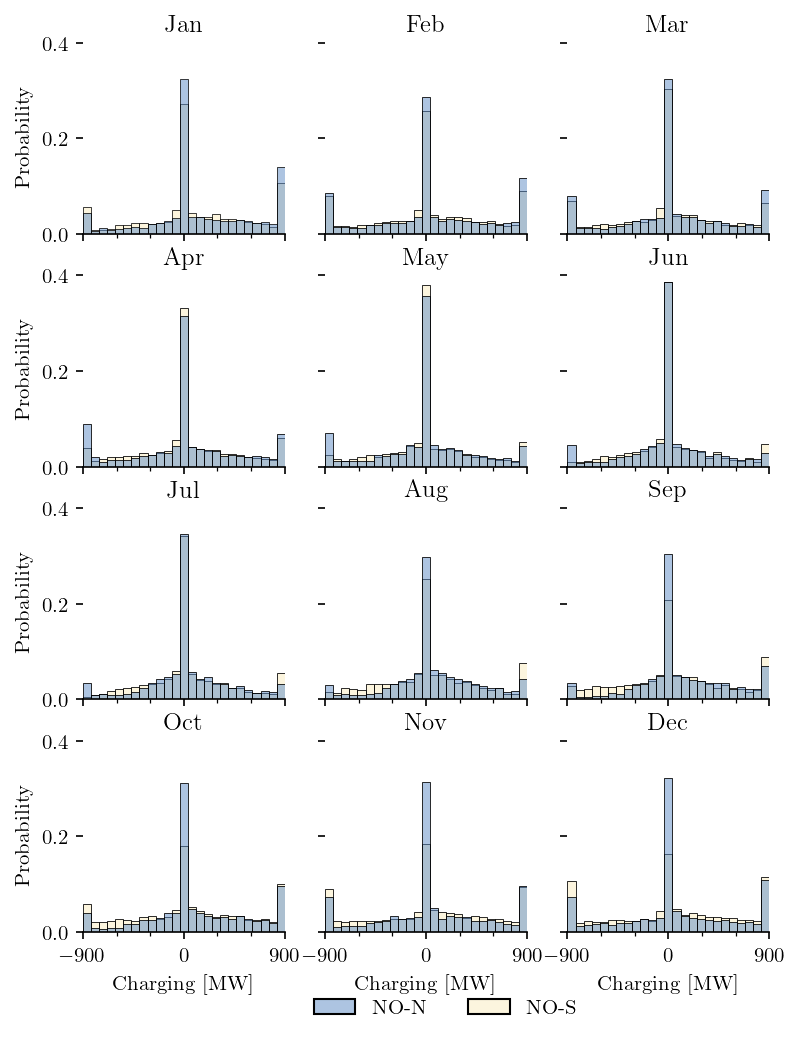

In [32]:
# Storage level distribution by month
fig, ax = plt.subplots(4,3, figsize=(15*cm, 20*cm), sharex=True, sharey=True)
for months, name in zip(range(0,12), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']):
    if months==10:
        sns.histplot(data=(pd.concat(su_flex)).loc[(slice(None),slice(months*30,(months+1)*30)), :].unstack().T,ax=ax[months//3, months%3], legend=True, stat="probability", bins=25, common_norm=False, palette=[cs["blue"], cs["yellow"]]);
        sns.move_legend(ax[months//3, months%3], "upper left", bbox_to_anchor=(-0.15,-0.25), ncol=2, frameon=False);
    else:
        sns.histplot(data=(pd.concat(su_flex)).loc[(slice(None),slice(months*30,(months+1)*30)), :].unstack().T,ax=ax[months//3, months%3], legend=False, stat="probability", bins=25, common_norm=False, palette=[cs["blue"], cs["yellow"]]);
    ax[months//3, months%3].set_xlim(-900,900);
    ax[months//3, months%3].set_title(f"{name}", y = 0.98);
    ax[months//3, months%3].xaxis.set_major_locator(ticker.MultipleLocator(900))
    ax[months//3, months%3].xaxis.set_minor_locator(ticker.MultipleLocator(300))
    # handles, labels = ax[3,1].get_legend_handles_labels();
    ax[3,months%3].set_xlabel("Charging [MW]");
    # ax[3,1].legend(handles, ["NO-N", "NO-S"], bbox_to_anchor=(0,-0.25), ncol=2, loc='upper left', fontsize=9, frameon=False);

for axis in ax.flatten():
    for loc in ["left", "right", "top"]:
        axis.spines[loc].set_visible(False)
if save_fig:
    fig.savefig("./figures/full-flex_usage-distr.pdf", bbox_inches='tight')
    fig.savefig("./figures/paper_plots/full-flex_usage-distr.pdf", bbox_inches='tight')


Plot 3: Storage level distribution

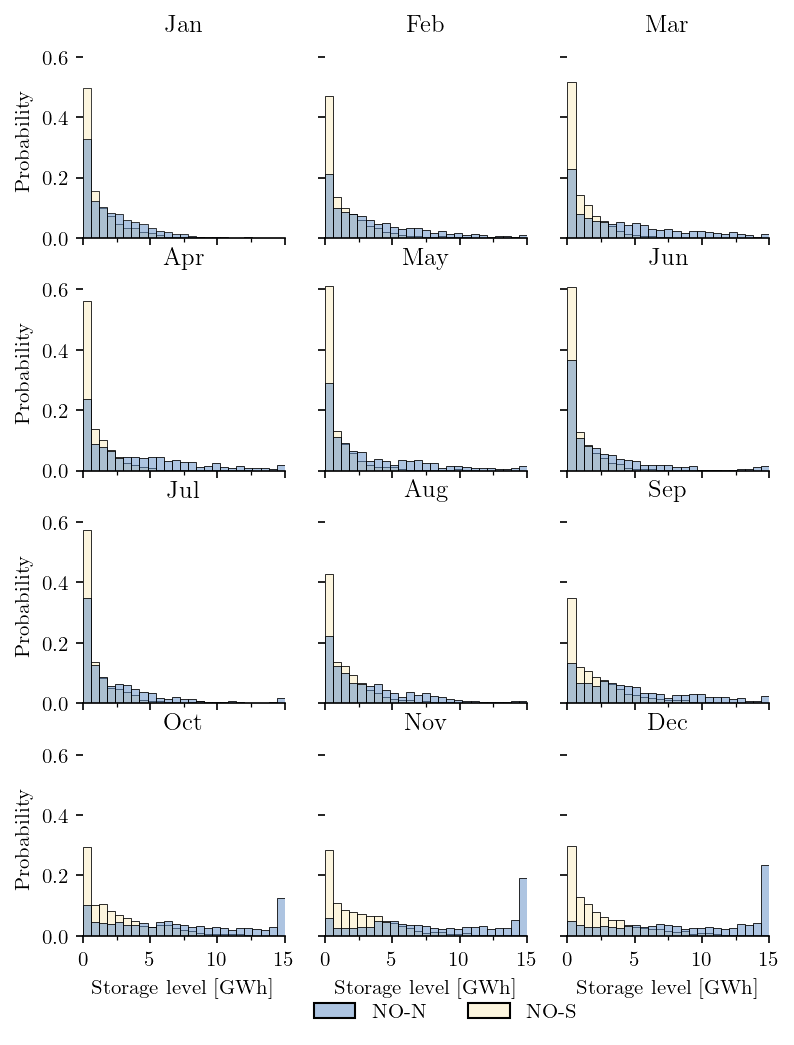

In [33]:
# Storage level distribution by month
fig, ax = plt.subplots(4,3, figsize=(15*cm, 20*cm), sharex=True, sharey=True)
for months, name in zip(range(0,12), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']):
    if months==10:
        sns.histplot(data=(pd.concat(sl_flex)/1e3).loc[(slice(None),slice(months*30,(months+1)*30)), :].unstack().T,ax=ax[months//3, months%3], legend=True, stat="probability", bins=25, binrange=(0,15), common_norm=False, palette=[cs["blue"], cs["yellow"]]);
        sns.move_legend(ax[months//3, months%3], "upper left", bbox_to_anchor=(-0.15,-0.25), ncol=2, frameon=False);
    else:
        sns.histplot(data=(pd.concat(sl_flex)/1e3).loc[(slice(None),slice(months*30,(months+1)*30)), :].unstack().T,ax=ax[months//3, months%3], legend=False, stat="probability", bins=25, binrange=(0,15), common_norm=False, palette=[cs["blue"], cs["yellow"]]);
    ax[months//3, months%3].set_xlim(left=0,right=15);
    ax[months//3, months%3].set_title(f"{name}");
    ax[months//3, months%3].xaxis.set_major_locator(ticker.MultipleLocator(5))
    ax[months//3, months%3].xaxis.set_minor_locator(ticker.MultipleLocator(2.5))
    # handles, labels = ax[3,1].get_legend_handles_labels();
    ax[3,months%3].set_xlabel("Storage level [GWh]");
    # ax[3,1].legend(handles, ["NO-N", "NO-S"], bbox_to_anchor=(0,-0.25), ncol=2, loc='upper left', fontsize=9, frameon=False);

for axis in ax.flatten():
    for loc in ["left", "right", "top"]:
        axis.spines[loc].set_visible(False)
if save_fig:
    fig.savefig("./figures/full-flex_level-distr.pdf", bbox_inches='tight')
    fig.savefig("./figures/paper_plots/full-flex_level-distr.pdf", bbox_inches='tight')


Plot 4: Net exports

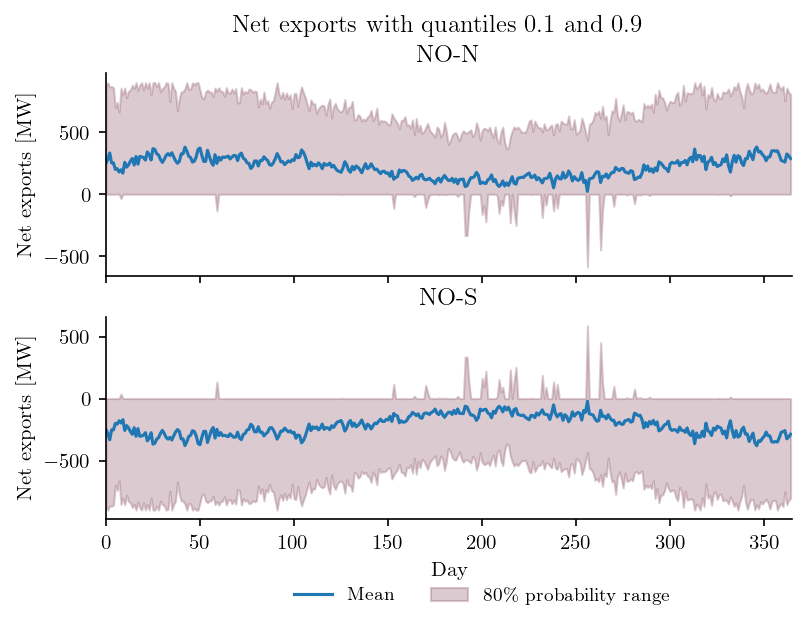

In [34]:
quantile = 0.1
fig, ax = plt.subplots(2,1, figsize=(15*cm, 10*cm), sharex=True)
fig.suptitle(f"Net exports with quantiles {quantile} and {1-quantile}");
for i,loc in enumerate(["NO-N", "NO-S"]):
    plot_mismatch((exports_flex[loc]-imports_flex[loc]), quantile=quantile,ax=ax[i], colour = cs["pink"]);
    ax[i].set_title(f"{loc}");
    ax[i].set_ylabel("Net exports [MW]");

for axis in ax.flatten():
    for loc in ["top", "right"]:
        axis.spines[loc].set_visible(False)
ax[1].legend(bbox_to_anchor=(0.25,-0.25), ncol=2, loc='upper left', fontsize=9, frameon=False);
ax[1].set_xlabel("Day");

# Comparison

In [35]:
cs

{'yellow': '#faecbe',
 'rose': '#f7cacd',
 'purple': '#d6b0d6',
 'burgundy': '#8a5066',
 'pink': '#8a5066',
 'blue': '#5c8bc4'}

In [36]:
colours = ["grey", "black", cs["purple"], cs["blue"], "darkolivegreen"]
scenario_names = ["orig", "no-flex", "trans", "stor", "full-flex"]

Plot 1: Comparison of average penalty values across scenarios

In [37]:
# # Plot penalties with quantiles.

# quantile = 0.1
# fig, ax = plt.subplots(2,1, figsize=(7.5*cm, 10*cm), sharex=True)
# for i,loc in enumerate(["NO-N", "NO-S"]):
#     for c, s, n in zip(colours, [penalties_orig, penalties, penalties_trans, penalties_storage, penalties_flex], scenario_names):
#         ax[i].plot(s[loc].mean(axis=1), c=c, label=n);
#     ax[i].set_title(f"{loc}");
#     ax[i].set_ylabel("Penalty values");
#     ax[i].set_xlim(0,365)
#     ax[i].set_ylim(bottom=0)
# ax[1].set_xlabel("Day");
# handles, labels = ax[1].get_legend_handles_labels()
# ax[1].legend(handles, labels, bbox_to_anchor=(-0.2,-0.25), ncol=3, loc='upper left', fontsize=8, frameon=False);
# if save_fig:
#     fig.savefig("./figures/comp_penalties.pdf", bbox_inches="tight")

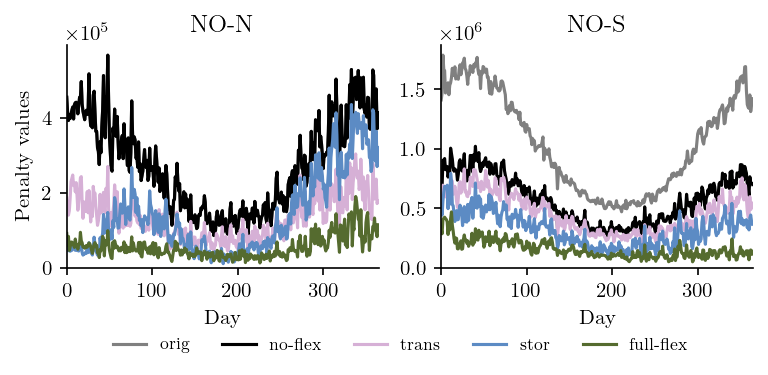

In [38]:
# Plot penalties with quantiles.

quantile = 0.1
fig, ax = plt.subplots(1,2, figsize=(15*cm, 5*cm), sharex=True)
for i,loc in enumerate(["NO-N", "NO-S"]):
    for c, s, n in zip(colours, [penalties_orig, penalties, penalties_trans, penalties_storage, penalties_flex], scenario_names):
        ax[i].plot(s[loc].mean(axis=1), c=c, label=n);
    ax[i].set_title(f"{loc}");
    ax[i].set_xlabel("Day");
    ax[i].set_xlim(0,365)
    ax[i].set_ylim(bottom=0)
ax[0].set_ylabel("Penalty values");
handles, labels = ax[1].get_legend_handles_labels()
ax[1].legend(handles, labels, bbox_to_anchor=(-1.1,-0.25), ncol=5, loc='upper left', fontsize=8, frameon=False);

for axis in ax.flatten():
    for loc in ["top", "right"]:
        axis.spines[loc].set_visible(False)
if save_fig:
    fig.savefig("./figures/comp_penalties_twocolumns.pdf", bbox_inches="tight")
    fig.savefig("./figures/paper_plots/comp_penalties.pdf", bbox_inches="tight")

In [39]:
for mism, name in zip([penalties, penalties_trans, penalties_storage, penalties_flex],["no-flex", "trans", "stor", "full-flex"]):
    for i in ["NO-N", "NO-S"]:
        print(i, name,  ((mism[i].mean(axis=1).sum())/(penalties_orig[i].mean(axis=1).sum())))

NO-N no-flex 1.0000000000000002
NO-S no-flex 0.5529719138135086
NO-N trans 0.49238437352054465
NO-S trans 0.4411740958100822
NO-N stor 0.4936382656834087
NO-S stor 0.3080735718405477
NO-N full-flex 0.20144844537042064
NO-S full-flex 0.14962269138756507


In [40]:
for mism, name in zip([penalties, penalties_trans, penalties_storage, penalties_flex],["no-flex", "trans", "stor", "full-flex"]):
    print(name,  ((pd.concat(mism).mean(axis=1).sum())/(pd.concat(penalties_orig).mean(axis=1).sum())))

no-flex 0.645913931161669
trans 0.4518212713823668
stor 0.3466544966801432
full-flex 0.1603978311933145


Plot 2: Comparison of mean storage level

In [41]:
# # Comparison of mean storage level

# quantile = 0.1
# fig, ax = plt.subplots(2,1, figsize=(7.5*cm, 10*cm), sharex=True)
# fig.suptitle(f"Mean storage level for different scenarios");
# for j,loc in enumerate(["NO-N", "NO-S"]):
#     for c, s ,n in zip([colours[3], colours[4]], [sl_storage, sl_flex], [scenario_names[3], scenario_names[4]]):
#         ax[j] = plot_mismatch(s[loc]/1e3, quantile=quantile, ax=ax[j], colour=c);
#     ax[j].set_title(f"{loc}")
#     ax[j].set_xlim(0,365)
#     ax[j].set_ylim(bottom=0)
#     ax[j].set_ylabel("Storage level [GWh]")
# ax[0].hlines(15, 0, 365, colors="grey", ls="dotted")
# ax[1].set_xlabel("Day")
# handles, labels = ax[1].get_legend_handles_labels();
# ax[1].legend(handles, [l + scen for l, scen in zip(labels, 2*[" (storage)"] + 2*[" (flex)"])], bbox_to_anchor=(0,-0.25), loc='upper left', fontsize=9, frameon=False);
# if save_fig:
#     fig.savefig("./figures/comp_level.pdf", bbox_inches='tight')


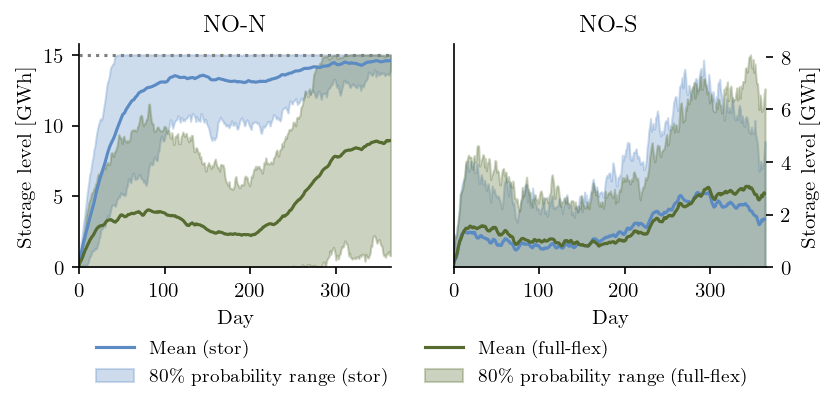

In [42]:
# Comparison of mean storage level

quantile = 0.1
fig, ax = plt.subplots(1,2, figsize=(15*cm,5*cm), sharex=True)
#fig.suptitle(f"Mean storage level for different scenarios");
for j,loc in enumerate(["NO-N", "NO-S"]):
    for c, s ,n in zip([colours[3], colours[4]], [sl_storage, sl_flex], [scenario_names[3], scenario_names[4]]):
        ax[j] = plot_mismatch(s[loc]/1e3, quantile=quantile, ax=ax[j], colour=c, linecolor=c);
    ax[j].set_title(f"{loc}")
    ax[j].set_xlim(0,365)
    ax[j].set_ylim(bottom=0)
    ax[j].set_xlabel("Day")
    ax[j].set_ylabel("Storage level [GWh]")
ax[0].hlines(15, 0, 365, colors="grey", ls="dotted")
ax[1].yaxis.set_label_position("right")
ax[1].yaxis.tick_right()
#ax[0].set_ylabel("Storage level [GWh]")
handles, labels = ax[1].get_legend_handles_labels();
ax[1].legend(handles, [l + scen for l, scen in zip(labels, 2*[" (stor)"] + 2*[" (full-flex)"])], bbox_to_anchor=(-1.2,-0.25), loc='upper left', fontsize=9, ncol=2, frameon=False);

for axis in ax.flatten():
    for loc in ["top", "right"]:
        axis.spines[loc].set_visible(False)
if save_fig:
    fig.savefig("./figures/comp_level_twocolumns.pdf", bbox_inches='tight')
    fig.savefig("./figures/paper_plots/comp_level.pdf", bbox_inches='tight')


# Surface plots


In [43]:
# Prepare surface plot
surface_vals = pd.read_csv(simulation, index_col=0)
sv = surface_vals.sort_values(["NO-N", "NO-S"]).set_index(["NO-N", "NO-S"])

sv.idxmin(axis=1)

sv.index = sv.index.set_levels(sv.index.levels[0].astype(int), level=0)
sv.index = sv.index.set_levels(sv.index.levels[1].astype(int), level=1)
sv_mins = sv.idxmin(axis=1)
second_highest = copy.deepcopy(sv)
for i in second_highest.index:
    second_highest.loc[i,sv_mins[i]] = np.nan
sh = second_highest.idxmin(axis=1)

sv_min_numeric = pd.Series(index=sv_mins.index)
for i in sv_min_numeric.index:
    if sv_mins[i]=="no-flex":
        sv_min_numeric[i] = 1
    elif sv_mins[i] == "trans":
        sv_min_numeric[i] = 2
    elif sv_mins[i] == "stor":
        sv_min_numeric[i] = 3
    else:
        sv_min_numeric[i] = 4
sv_two_numeric = pd.Series(index=sh.index)
for i in sv_two_numeric.index:
    if sh[i]=="no-flex":
        sv_two_numeric[i] = 1
    elif sh[i] == "trans":
        sv_two_numeric[i] = 2
    elif sh[i] == "stor":
        sv_two_numeric[i] = 3
    elif sh[i] == "full-flex":
        sv_two_numeric[i] = 4

/tmp/ipykernel_1578546/2829409668.py:15: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  sv_min_numeric = pd.Series(index=sv_mins.index)
/tmp/ipykernel_1578546/2829409668.py:25: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  sv_two_numeric = pd.Series(index=sh.index)


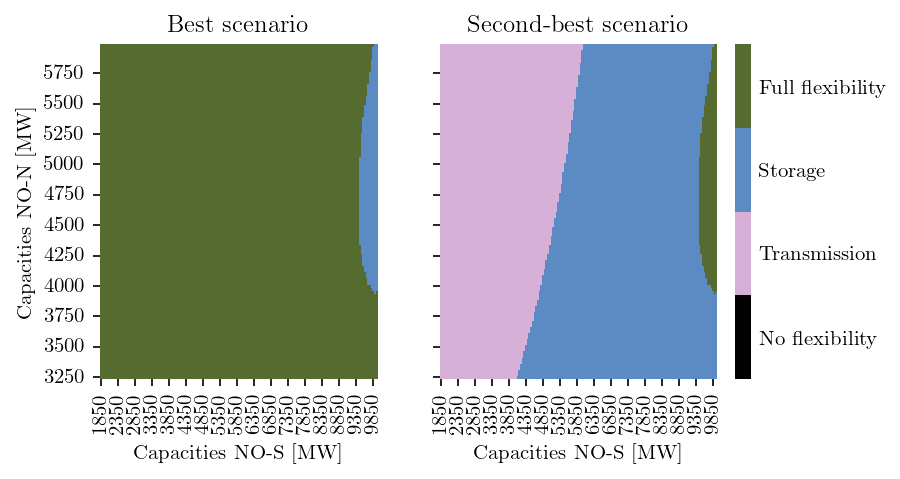

In [44]:
# Plot cheapest and second-cheapest scenario
fig, ax = plt.subplots(1,2,figsize=(15*cm, 7.5*cm), sharey=True, gridspec_kw={'width_ratios': [0.8, 1]})
xtl = np.arange(3250,6000,200)
ytl = np.arange(1800,10000,400)
ax[0].set_title("Best scenario")
sns.heatmap(data=sv_min_numeric.unstack(), cmap =colours[1:], vmin=1, vmax=5, cbar=False, xticklabels=10, yticklabels=10, ax=ax[0], rasterized=True) #rasterized for saving without the lines in the heatmap
ax[0].set_ylim(ax[0].get_ylim()[::-1]);
ax[1].set_title("Second-best scenario")
sns.heatmap(data=sv_two_numeric.unstack(), cmap =colours[1:], vmin=1, vmax=5, cbar_kws={"ticks": [1.5,2.5,3.5,4.5]}, xticklabels=10, yticklabels=10, ax=ax[1], rasterized=True)
ax[1].set_ylim(ax[1].get_ylim()[::-1]);
cb = ax[1].collections[-1].colorbar
cb.ax.set_yticklabels(["No flexibility", "Transmission", "Storage", "Full flexibility"]);
cb.ax.tick_params(axis='both', which='both', length=0)
ax[0].set_xlabel("Capacities NO-S [MW]");
ax[0].set_ylabel("Capacities NO-N [MW]");
ax[1].set_xlabel("Capacities NO-S [MW]");
ax[1].set_ylabel("");
if save_fig:
    fig.savefig("./figures/surfaces.pdf", bbox_inches='tight')
    fig.savefig("./figures/paper_plots/surfaces.pdf", bbox_inches='tight')

In [45]:
# # Plot cheapest and second-cheapest scenario
# fig, ax = plt.subplots(2,1,figsize=(7.5*cm, 15*cm), sharey=True,sharex=True)
# xtl = np.arange(3250,6000,200)
# ytl = np.arange(1800,10000,400)
# ax[0].set_title("Best scenario")
# sns.heatmap(data=sv_min_numeric.unstack(), cmap =colours[1:], vmin=1, vmax=5, cbar_kws={"ticks": [1.5,2.5,3.5,4.5]}, xticklabels=10, yticklabels=10, ax=ax[0], rasterized=True) #rasterized for saving without the lines in the heatmap
# ax[0].set_ylim(ax[0].get_ylim()[::-1]);
# cb = ax[0].collections[-1].colorbar
# cb.ax.set_yticklabels(["No flexibility", "Transmission", "Storage", "Full flexibility"]);
# ax[1].set_title("Second-best scenario")
# sns.heatmap(data=sv_two_numeric.unstack(), cmap =colours[1:], vmin=1, vmax=5, cbar_kws={"ticks": [1.5,2.5,3.5,4.5]}, xticklabels=10, yticklabels=10, ax=ax[1], rasterized=True)
# ax[1].set_ylim(ax[1].get_ylim()[::-1]);
# cb = ax[1].collections[-1].colorbar
# cb.ax.set_yticklabels(["No flexibility", "Transmission", "Storage", "Full flexibility"]);
# cb.ax.tick_params(axis='both', which='both', length=0)
# ax[0].set_xlabel("");
# ax[0].set_ylabel("Capacities NO-N [MW]");
# ax[1].set_xlabel("Capacities NO-S [MW]");
# ax[1].set_ylabel("Capacities NO-N [MW]");
# if save_fig:
#     fig.savefig("./figures/surfaces_column.pdf", bbox_inches='tight')


# Sensitivity analysis

In [46]:
# Sensitivity analysis set-up
transmission_caps = [factor * 900. for factor in [0.5, 0.9, 1.1, 1.5]]
storage_caps = [0.5*storage_cap, 0.9 * storage_cap, 1.1 * storage_cap, 1.5 * storage_cap]
generation_caps = [0.5*generation_cap, 0.9*generation_cap, 1.1*generation_cap, 1.5*generation_cap, np.array([900., 450.]), np.array([450.,900.]), np.array([900., 1350.]), np.array([1350., 900.])]

In [47]:
# Transmission sensitivity analysis
sens_names = [f"trans{factor}" for factor in [0.5, 0.9, 1.1, 1.5]]
sens_runs = list(product(transmission_caps, [storage_cap], [generation_cap]))

In [49]:
# Compare sensitivity analysis runs
## Load data
simulations = {}

for name in sens_names:
    simulations[name] = pd.read_csv(f"./results/sensitivity_analysis/{name}.csv", index_col=0)

if save_files:
    ## Compare optimal capacities
    opt_caps = {}
    opt_caps["standard"] = optimal_capacities
    for name in sens_names:
        opt_caps[name] = pd.DataFrame(simulations[name].loc[simulations[name].idxmin()[scenarios]][regions].values, index = scenarios, columns = regions)
    # ### Overwrite by initial capacities, if below them.
    #     for i in opt_caps[name].index:
    #         if opt_caps[name].loc[i, "NO-N"] == 3250:
    #             opt_caps[name].loc[i, "NO-N"] = 3257
    #         if opt_caps[name].loc[i, "NO-S"] == 1800:
    #             opt_caps[name].iloc[i, "NO-S"] = 1811


    ## Compare penalties
    pen = {}
    pen["standard"] = pd.DataFrame(index = scenarios, columns = regions)
    for i in regions:
        pen["standard"].loc["no-flex", i] = penalties[i].sum().mean()
        pen["standard"].loc["trans", i] = penalties_trans[i].sum().mean()
        pen["standard"].loc["stor", i] = penalties_storage[i].sum().mean()
        pen["standard"].loc["full-flex", i] = penalties_flex[i].sum().mean()

    for name, assumptions in zip(sens_names, sens_runs):
        pen[name] = pd.DataFrame(index = scenarios, columns = regions)
        noflex_pen, _ = sim_no_flex(opt_caps[name].loc["no-flex"], batch_size=batch_size, cap_factors_data=cf_ts, demand_data= dem_ts)
        trans_pen, _, _, _ = sim_trans(opt_caps[name].loc["trans"], assumptions[0], batch_size=batch_size, cap_factors_data=cf_ts, demand_data=dem_ts)
        stor_pen, _, _, _ = sim_storage(opt_caps[name].loc["stor"], assumptions[1],assumptions[2], assumptions[2],batch_size,cf_ts, dem_ts, eff_c, eff_d)
        fullflex_pen, _, _, _, _, _ = sim_full_flex(opt_caps[name].loc["full-flex"],assumptions[0],assumptions[1],assumptions[2], assumptions[2],batch_size,cf_ts, dem_ts, eff_c, eff_d)
        for i in regions:
            pen[name].loc["no-flex", i] = noflex_pen[i].sum().mean()
            pen[name].loc["trans", i] = trans_pen[i].sum().mean()
            pen[name].loc["stor", i] = stor_pen[i].sum().mean()
            pen[name].loc["full-flex", i] = fullflex_pen[i].sum().mean()

    ## Reordering
    capacities_sens_trans = pd.concat(opt_caps)
    penalties_sens_trans = pd.concat(pen)

    capacities_sens_trans = capacities_sens_trans.reindex(['trans0.5', 'trans0.9', 'standard', 'trans1.1', 'trans1.5'], level=0)
    penalties_sens_trans = penalties_sens_trans.reindex(['trans0.5', 'trans0.9', 'standard', 'trans1.1', 'trans1.5'], level=0)


    capacities_sens_trans.to_csv("./results/sensitivity_analysis/capacities/sens_trans.csv")
    penalties_sens_trans.to_csv("./results/sensitivity_analysis/penalties/sens_trans.csv")
else:
    capacities_sens_trans = pd.read_csv("./results/sensitivity_analysis/capacities/sens_trans.csv", index_col=[0,1])
    penalties_sens_trans = pd.read_csv("./results/sensitivity_analysis/penalties/sens_trans.csv", index_col=[0,1])

In [50]:
optimal_capacities

,NO-N,NO-S
no-flex,3257.0,4700.0
trans,3257.0,3800.0
stor,3257.0,6450.0
full-flex,3257.0,5550.0


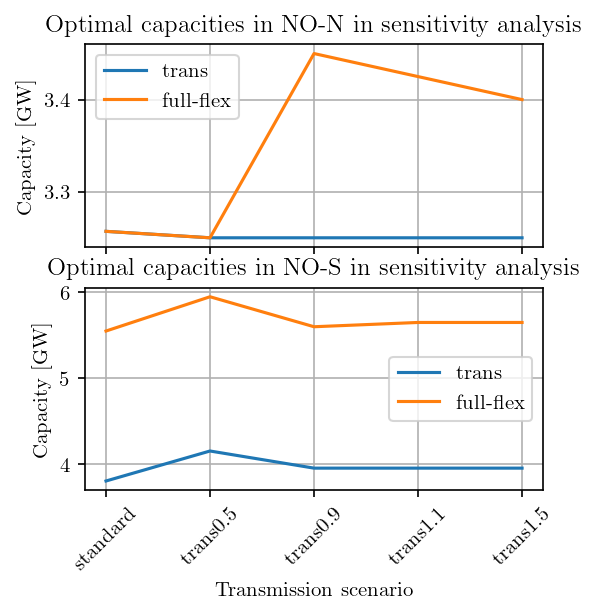

In [51]:
# Plot sensitivity analysis for variation of transmission capacities
fig, ax = plt.subplots(2,1, figsize = (10*cm, 10*cm), sharex=True)
relevant_scenarios = ["trans", "full-flex"]

for i, loc in enumerate(regions):
    (capacities_sens_trans[loc].loc[:,relevant_scenarios].unstack()/1e3).plot(ax=ax[i])
    ax[i].set_title("Optimal capacities in " + loc + " in sensitivity analysis  ")
    ax[i].set_xticks(np.arange(0, len(capacities_sens_trans[loc].loc[:,relevant_scenarios].unstack().index)))
    ax[i].set_xticklabels(capacities_sens_trans[loc].loc[:,relevant_scenarios].unstack().index, rotation=45)
    ax[i].set_ylabel("Capacity [GW]")
    ax[i].set_xlabel("Transmission scenario")
    ax[i].grid()

if save_fig:
    fig.savefig("./figures/sensitivity_trans_caps.pdf", bbox_inches="tight")

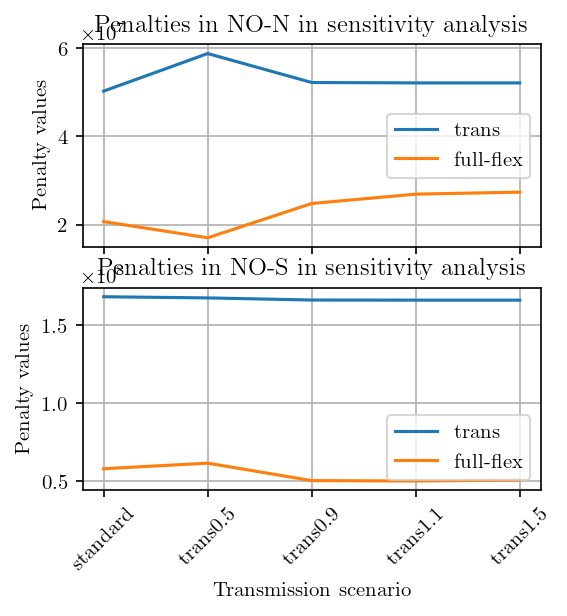

In [52]:
# Plot sensitivity analysis for variation of transmission capacities
fig, ax = plt.subplots(2,1, figsize = (10*cm, 10*cm), sharex=True)
relevant_scenarios = ["trans", "full-flex"]

for i, loc in enumerate(regions):
    (penalties_sens_trans[loc].loc[:,relevant_scenarios].unstack()).plot(ax=ax[i])
    ax[i].set_title("Penalties in " + loc + " in sensitivity analysis  ")
    ax[i].set_xticks(np.arange(0, len(penalties_sens_trans[loc].loc[:,relevant_scenarios].unstack().index)))
    ax[i].set_xticklabels(penalties_sens_trans[loc].loc[:,relevant_scenarios].unstack().index, rotation=45)
    ax[i].set_ylabel("Penalty values")
    ax[i].set_xlabel("Transmission scenario")
    ax[i].grid()

if save_fig:
    fig.savefig("./figures/sensitivity_trans_penalties.pdf", bbox_inches="tight")

Compare optimal capacities (or changes of those).
Compare the penalty values for those in both regions (which we do not have in the csv file so far), so need to simulate.

In [53]:
# Storage sensitivity analysis
sens_names = [f"storage{factor}" for factor in [0.5, 0.9, 1.1, 1.5]]
sens_runs = list(product([transmission_cap], storage_caps, [generation_cap]))

In [55]:
# Compare sensitivity analysis runs
## Load data
simulations = {}

for name in sens_names:
    simulations[name] = pd.read_csv(f"./results/sensitivity_analysis/{name}.csv", index_col=0)

## Compare optimal capacities
opt_caps = {}
opt_caps["standard"] = optimal_capacities
for name in sens_names:
    opt_caps[name] = pd.DataFrame(simulations[name].loc[simulations[name].idxmin()[scenarios]][regions].values, index = scenarios, columns = regions)
# ### Overwrite by initial capacities, if below them.
#     for i in opt_caps[name].index:
#         if opt_caps[name].loc[i, "NO-N"] == 3250:
#             opt_caps[name].loc[i, "NO-N"] = 3257
#         if opt_caps[name].loc[i, "NO-S"] == 1800:
#             opt_caps[name].iloc[i, "NO-S"] = 1811


## Compare penalties
if save_files:
    pen = {}
    pen["standard"] = pd.DataFrame(index = scenarios, columns = regions)
    for i in regions:
        pen["standard"].loc["no-flex", i] = penalties[i].sum().mean()
        pen["standard"].loc["trans", i] = penalties_trans[i].sum().mean()
        pen["standard"].loc["stor", i] = penalties_storage[i].sum().mean()
        pen["standard"].loc["full-flex", i] = penalties_flex[i].sum().mean()

    for name, assumptions in zip(sens_names, sens_runs):
        pen[name] = pd.DataFrame(index = scenarios, columns = regions)
        noflex_pen, _ = sim_no_flex(opt_caps[name].loc["no-flex"], batch_size=batch_size, cap_factors_data=cf_ts, demand_data= dem_ts)
        trans_pen, _, _, _ = sim_trans(opt_caps[name].loc["trans"], assumptions[0], batch_size=batch_size, cap_factors_data=cf_ts, demand_data=dem_ts)
        stor_pen, _, _, _ = sim_storage(opt_caps[name].loc["stor"], assumptions[1],assumptions[2], assumptions[2],batch_size,cf_ts, dem_ts, eff_c, eff_d)
        fullflex_pen, _, _, _, _, _ = sim_full_flex(opt_caps[name].loc["full-flex"],assumptions[0],assumptions[1],assumptions[2], assumptions[2],batch_size,cf_ts, dem_ts, eff_c, eff_d)
        for i in regions:
            pen[name].loc["no-flex", i] = noflex_pen[i].sum().mean()
            pen[name].loc["trans", i] = trans_pen[i].sum().mean()
            pen[name].loc["stor", i] = stor_pen[i].sum().mean()
            pen[name].loc["full-flex", i] = fullflex_pen[i].sum().mean()

    ## Reordering
    capacities_sens_storage = pd.concat(opt_caps)
    penalties_sens_storage = pd.concat(pen)

    capacities_sens_storage = capacities_sens_storage.reindex(['storage0.5', 'storage0.9', 'standard', 'storage1.1', 'storage1.5'], level=0)
    penalties_sens_storage = penalties_sens_storage.reindex(['storage0.5', 'storage0.9', 'standard', 'storage1.1', 'storage1.5'], level=0)


    capacities_sens_storage.to_csv("./results/sensitivity_analysis/capacities/sens_storage.csv")
    penalties_sens_storage.to_csv("./results/sensitivity_analysis/penalties/sens_storage.csv")
else:
    capacities_sens_storage = pd.read_csv("./results/sensitivity_analysis/capacities/sens_storage.csv", index_col=[0,1])
    penalties_sens_storage = pd.read_csv("./results/sensitivity_analysis/penalties/sens_storage.csv", index_col=[0,1])



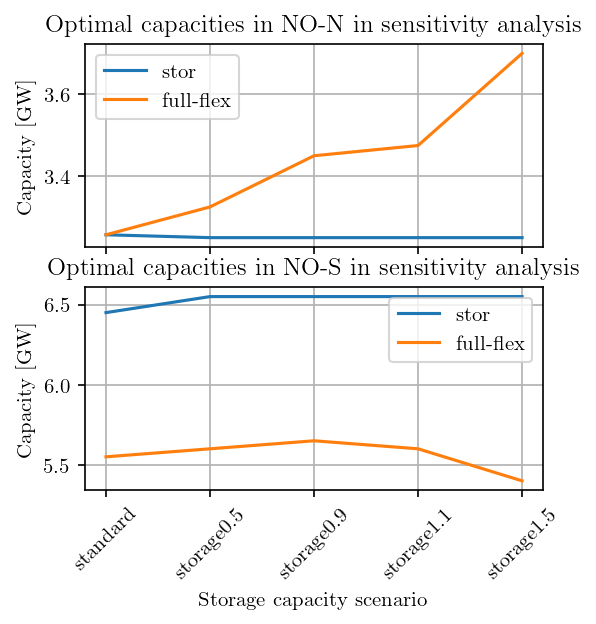

In [56]:
# Plot sensitivity analysis for variation of storage capacities
fig, ax = plt.subplots(2,1, figsize = (10*cm, 10*cm), sharex=True)
relevant_scenarios = ["stor", "full-flex"]

for i, loc in enumerate(regions):
    (capacities_sens_storage[loc].loc[:,relevant_scenarios].unstack()/1e3).plot(ax=ax[i])
    ax[i].set_title("Optimal capacities in " + loc + " in sensitivity analysis  ")
    ax[i].set_xticks(np.arange(0, len(capacities_sens_storage[loc].loc[:,relevant_scenarios].unstack().index)))
    ax[i].set_xticklabels(capacities_sens_storage[loc].loc[:,relevant_scenarios].unstack().index, rotation=45)
    ax[i].set_ylabel("Capacity [GW]")
    ax[i].set_xlabel("Storage capacity scenario")
    ax[i].grid()

if save_fig:
    fig.savefig("./figures/sensitivity_stor_caps.pdf", bbox_inches="tight")

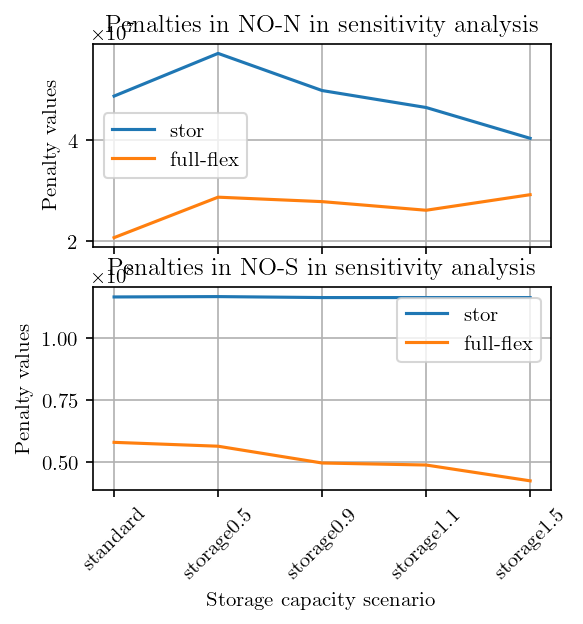

In [57]:
# Plot sensitivity analysis for variation of storage capacities
fig, ax = plt.subplots(2,1, figsize = (10*cm, 10*cm), sharex=True)
relevant_scenarios = ["stor", "full-flex"]

for i, loc in enumerate(regions):
    (penalties_sens_storage[loc].loc[:,relevant_scenarios].unstack()).plot(ax=ax[i])
    ax[i].set_title("Penalties in " + loc + " in sensitivity analysis  ")
    ax[i].set_xticks(np.arange(0, len(penalties_sens_storage[loc].loc[:,relevant_scenarios].unstack().index)))
    ax[i].set_xticklabels(penalties_sens_storage[loc].loc[:,relevant_scenarios].unstack().index, rotation=45)
    ax[i].set_ylabel("Penalty values")
    ax[i].set_xlabel("Storage capacity scenario")
    ax[i].grid()

if save_fig:
    fig.savefig("./figures/sensitivity_stor_penalties.pdf", bbox_inches="tight")

In [58]:
# Generation sensitivity analysis
sens_names = ["gen_0.5", "gen_0.9", "gen_1.1", "gen_1.5", "gen_N0.5", "gen_S0.5", "gen_N1.5", "gen_S1.5"]
sens_runs = list(product([transmission_cap], [storage_cap], generation_caps))

In [59]:
# Compare sensitivity analysis runs
## Load data
simulations = {}

for name in sens_names:
    simulations[name] = pd.read_csv(f"./results/sensitivity_analysis/{name}.csv", index_col=0)

## Compare optimal capacities
opt_caps = {}
opt_caps["standard"] = optimal_capacities
for name in sens_names:
    opt_caps[name] = pd.DataFrame(simulations[name].loc[simulations[name].idxmin()[scenarios]][regions].values, index = scenarios, columns = regions)
# ### Overwrite by initial capacities, if below them.
#     for i in opt_caps[name].index:
#         if opt_caps[name].loc[i, "NO-N"] == 3250:
#             opt_caps[name].loc[i, "NO-N"] = 3257
#         if opt_caps[name].loc[i, "NO-S"] == 1800:
#             opt_caps[name].iloc[i, "NO-S"] = 1811


## Compare penalties
if save_files:
    pen = {}
    pen["standard"] = pd.DataFrame(index = scenarios, columns = regions)
    for i in regions:
        pen["standard"].loc["no-flex", i] = penalties[i].sum().mean()
        pen["standard"].loc["trans", i] = penalties_trans[i].sum().mean()
        pen["standard"].loc["stor", i] = penalties_storage[i].sum().mean()
        pen["standard"].loc["full-flex", i] = penalties_flex[i].sum().mean()

    for name, assumptions in zip(sens_names, sens_runs):
        pen[name] = pd.DataFrame(index = scenarios, columns = regions)
        noflex_pen, _ = sim_no_flex(opt_caps[name].loc["no-flex"], batch_size=batch_size, cap_factors_data=cf_ts, demand_data= dem_ts)
        trans_pen, _, _, _ = sim_trans(opt_caps[name].loc["trans"], assumptions[0], batch_size=batch_size, cap_factors_data=cf_ts, demand_data=dem_ts)
        stor_pen, _, _, _ = sim_storage(opt_caps[name].loc["stor"], assumptions[1],assumptions[2], assumptions[2],batch_size,cf_ts, dem_ts, eff_c, eff_d)
        fullflex_pen, _, _, _, _, _ = sim_full_flex(opt_caps[name].loc["full-flex"],assumptions[0],assumptions[1],assumptions[2], assumptions[2],batch_size,cf_ts, dem_ts, eff_c, eff_d)
        for i in regions:
            pen[name].loc["no-flex", i] = noflex_pen[i].sum().mean()
            pen[name].loc["trans", i] = trans_pen[i].sum().mean()
            pen[name].loc["stor", i] = stor_pen[i].sum().mean()
            pen[name].loc["full-flex", i] = fullflex_pen[i].sum().mean()

    ## Reordering
    capacities_sens_generation = pd.concat(opt_caps)
    penalties_sens_generation = pd.concat(pen)

    capacities_sens_generation = capacities_sens_generation.reindex(["gen_0.5", "gen_N0.5", "gen_S0.5", "gen_0.9", "standard", "gen_1.1", "gen_1.5",  "gen_N1.5", "gen_S1.5"], level=0)
    penalties_sens_generation = penalties_sens_generation.reindex(["gen_0.5", "gen_N0.5", "gen_S0.5", "gen_0.9", "standard", "gen_1.1", "gen_1.5",  "gen_N1.5", "gen_S1.5"], level=0)

    capacities_sens_generation.to_csv("./results/sensitivity_analysis/capacities/sens_generation.csv")
    penalties_sens_generation.to_csv("./results/sensitivity_analysis/penalties/sens_generation.csv")
else:
    capacities_sens_generation = pd.read_csv("./results/sensitivity_analysis/capacities/sens_generation.csv", index_col=[0,1])
    penalties_sens_generation = pd.read_csv("./results/sensitivity_analysis/penalties/sens_generation.csv", index_col=[0,1])



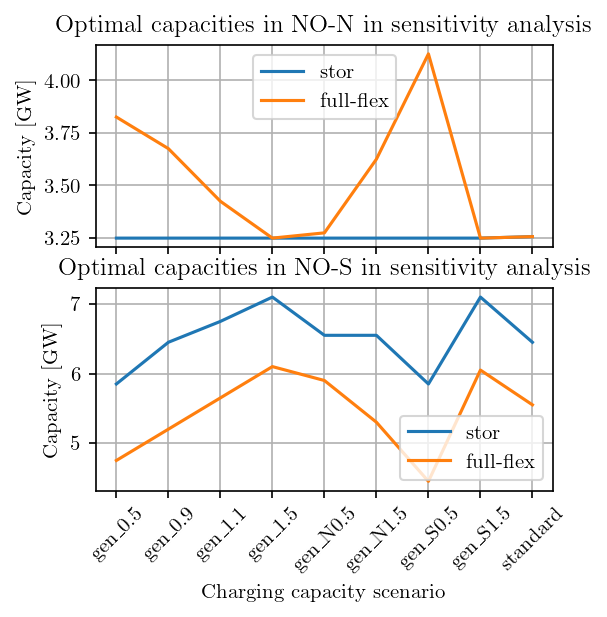

In [60]:
# Plot sensitivity analysis for variation of charging capacities
fig, ax = plt.subplots(2,1, figsize = (10*cm, 10*cm), sharex=True)
relevant_scenarios = ["stor", "full-flex"]

for i, loc in enumerate(regions):
    (capacities_sens_generation[loc].loc[:,relevant_scenarios].unstack()/1e3).plot(ax=ax[i])
    ax[i].set_title("Optimal capacities in " + loc + " in sensitivity analysis  ")
    ax[i].set_xticks(np.arange(0, len(capacities_sens_generation[loc].loc[:,relevant_scenarios].unstack().index)))
    ax[i].set_xticklabels(capacities_sens_generation[loc].loc[:,relevant_scenarios].unstack().index, rotation=45)
    ax[i].set_ylabel("Capacity [GW]")
    ax[i].set_xlabel("Charging capacity scenario")
    ax[i].grid()

if save_fig:
    fig.savefig("./figures/sensitivity_gen_caps.pdf", bbox_inches="tight")

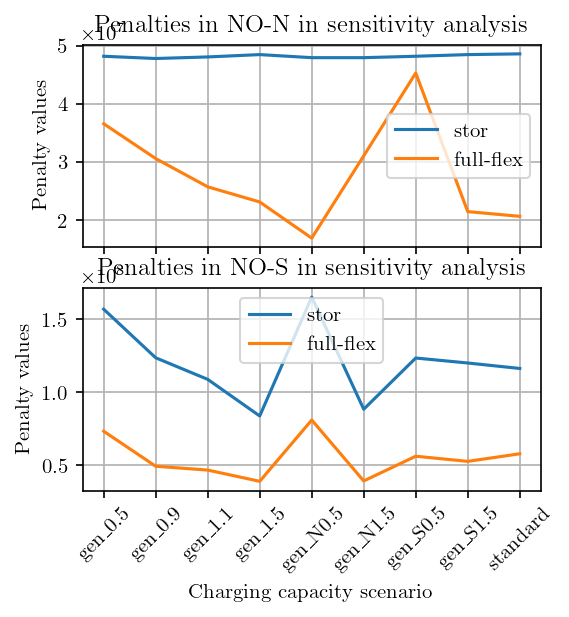

In [61]:
# Plot sensitivity analysis for variation of charging capacities
fig, ax = plt.subplots(2,1, figsize = (10*cm, 10*cm), sharex=True)
relevant_scenarios = ["stor", "full-flex"]

for i, loc in enumerate(regions):
    (penalties_sens_generation[loc].loc[:,relevant_scenarios].unstack()).plot(ax=ax[i])
    ax[i].set_title("Penalties in " + loc + " in sensitivity analysis  ")
    ax[i].set_xticks(np.arange(0, len(penalties_sens_generation[loc].loc[:,relevant_scenarios].unstack().index)))
    ax[i].set_xticklabels(penalties_sens_generation[loc].loc[:,relevant_scenarios].unstack().index, rotation=45)
    ax[i].set_ylabel("Penalty values")
    ax[i].set_xlabel("Charging capacity scenario")
    ax[i].grid()

if save_fig:
    fig.savefig("./figures/sensitivity_gen_penalties.pdf", bbox_inches="tight")

## Demand
Variations in all regions (separately and joined), based on already existing, optimal capacities. Representing unexpected change.

In [62]:
sens_runs = [np.array([0.9,0.9]), np.array([0.9,1]), np.array([1,0.9]), np.array([1.1,1]), np.array([1,1.1]), np.array([1.1,1.1])]
sens_names = ["dem_0.9", "dem_N0.9", "dem_S0.9", "dem_N1.1", "dem_S1.1", "dem_1.1"]

In [63]:
# Investigate penalties depending on demand
if save_files:
    pen = {}

    pen["standard"] = pd.DataFrame(index = scenarios, columns = regions)
    for i in regions:
        pen["standard"].loc["no-flex", i] = penalties[i].sum().mean()
        pen["standard"].loc["trans", i] = penalties_trans[i].sum().mean()
        pen["standard"].loc["stor", i] = penalties_storage[i].sum().mean()
        pen["standard"].loc["full-flex", i] = penalties_flex[i].sum().mean()

    ## Compare penalties
    for name, assumptions in zip(sens_names, sens_runs):
        pen[name] = pd.DataFrame(index = scenarios, columns = regions)
        noflex_pen, _ = sim_no_flex(optimal_capacities.loc["no-flex"], batch_size=batch_size, cap_factors_data=cf_ts, demand_data= dem_ts * assumptions)
        trans_pen, _, _, _ = sim_trans(optimal_capacities.loc["trans"], transmission_cap, batch_size=batch_size, cap_factors_data=cf_ts, demand_data=dem_ts * assumptions)
        stor_pen, _, _, _ = sim_storage(optimal_capacities.loc["stor"], storage_cap,generation_cap, generation_cap,batch_size,cf_ts, dem_ts * assumptions, eff_c, eff_d)
        fullflex_pen, _, _, _, _, _ = sim_full_flex(optimal_capacities.loc["full-flex"],transmission_cap,storage_cap,generation_cap, generation_cap,batch_size,cf_ts, dem_ts * assumptions, eff_c, eff_d)
        for i in regions:
            pen[name].loc["no-flex", i] = noflex_pen[i].sum().mean()
            pen[name].loc["trans", i] = trans_pen[i].sum().mean()
            pen[name].loc["stor", i] = stor_pen[i].sum().mean()
            pen[name].loc["full-flex", i] = fullflex_pen[i].sum().mean()

    ## Plot
    penalties_sens_demand = pd.concat(pen)
    penalties_sens_demand = penalties_sens_demand.reindex(["dem_0.9", "dem_N0.9", "dem_S0.9", "standard", "dem_N1.1", "dem_S1.1", "dem_1.1"], level=0)


    penalties_sens_demand.to_csv("./results/sensitivity_analysis/penalties/sens_demand.csv")
else:
    penalties_sens_demand = pd.read_csv("./results/sensitivity_analysis/penalties/sens_demand.csv", index_col=[0,1])


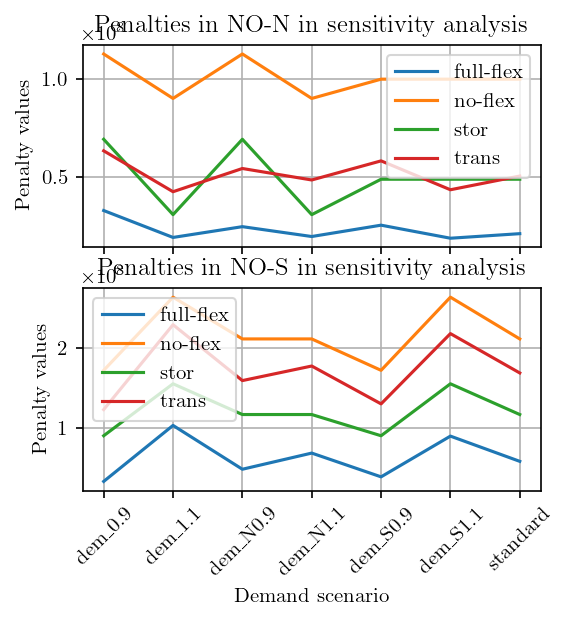

In [64]:
# Plot sensitivity analysis for variation of demand
fig, ax = plt.subplots(2,1, figsize = (10*cm, 10*cm), sharex=True)
relevant_scenarios = ["no-flex", "trans", "stor", "full-flex"]

for i, loc in enumerate(regions):
    (penalties_sens_demand[loc].loc[:,relevant_scenarios].unstack()).plot(ax=ax[i])
    ax[i].set_title("Penalties in " + loc + " in sensitivity analysis  ")
    ax[i].set_xticks(np.arange(0, len(penalties_sens_demand[loc].loc[:,relevant_scenarios].unstack().index)))
    ax[i].set_xticklabels(penalties_sens_demand[loc].loc[:,relevant_scenarios].unstack().index, rotation=45)
    ax[i].set_ylabel("Penalty values")
    ax[i].set_xlabel("Demand scenario")
    ax[i].grid()

if save_fig:
    fig.savefig("./figures/sensitivity_demand_penalties.pdf", bbox_inches="tight")